In [1]:
import sys
assert sys.version_info >= (3, 5)
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import itertools
import os
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Address for saving the figures
RESULTS_PATH = os.path.join(".", "", "results")
os.makedirs(RESULTS_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(RESULTS_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Load Dataset

In [2]:
# reading dataset
df = pd.read_csv('data/Iris.csv')
df

,Sepal_Length,Sepal_Width,Petal_Length,Petal_Width,Class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

## Split Dataset

In [4]:
X = df[['Sepal_Length', 'Sepal_Width', 'Petal_Length', 'Petal_Width']].to_numpy()
y = df[['Class']].to_numpy().flatten()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

## Create Gaussian Naive Bayes Classifier

In [5]:
# MyGaussianNB will be the class that will have the Gaussian naive bayes classifier implimentation
class MyGaussianNB:
    
    def __init__(self, var_smoothing=1e-3):
        self.var_smoothing = var_smoothing
    
    def separate_by_classes(self, X, y):
        ''' This function separates our dataset in subdatasets by classes '''
        self.classes = np.unique(y)
        classes_index = {}
        subdatasets = {}
        cls, counts = np.unique(y, return_counts=True)
        self.class_freq = dict(zip(cls, counts))
        for class_type in self.classes:
            classes_index[class_type] = np.argwhere(y==class_type)[:, 0]
            subdatasets[class_type] = X[classes_index[class_type], :]
            self.class_freq[class_type] = self.class_freq[class_type]/sum(list(self.class_freq.values()))
        return subdatasets
    
    def fit(self, X, y):
        ''' The fitting function '''
        separated_X = self.separate_by_classes(X, y)
        self.means = {}
        self.stds = {}
        for class_type in self.classes:
            # Here we calculate the mean and the standart deviation from datasets
            self.means[class_type] = np.mean(separated_X[class_type], axis=0)
            self.stds[class_type] = np.std(separated_X[class_type], axis=0)
        return self
    
    def predict_proba(self, x):
        ''' This function predicts the probability for every class '''
        
        # prior distribution
        self.class_prob = {cls:math.log(self.class_freq[cls], math.e) for cls in self.classes}
        for cls in self.classes:
            for i in range(len(x)):
                mean = self.means[cls][i]
                std = max(self.var_smoothing, self.stds[cls][i])
                
                tmp = math.log(2 * math.pi * std, math.e) + (((x[i] - mean) / std) ** 2)
                self.class_prob[cls] += (-1/2)*tmp
        return self.class_prob
    
    def predict(self, X):
        ''' This funtion predicts the class of a sample '''
        pred = np.empty(len(X), dtype=object)
        for idx, x in enumerate(X):
            pred_class = None
            max_prob = -math.inf
            for cls, prob in self.predict_proba(x).items():
                if prob>max_prob:
                    max_prob = prob
                    pred_class = cls
            pred[idx] = pred_class
        return pred

### Gaussian Naive Bayes Classifier Report

In [6]:
clf = MyGaussianNB()
y_pred = clf.fit(X_train, y_train).predict(X_test)

print('Accuracy: %.2f' % accuracy_score(y_pred, y_test))

Accuracy: 0.95


Saving figure my_nbc_confusion_matrix


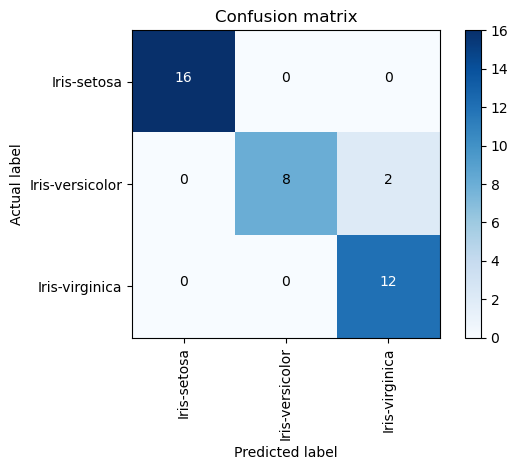

In [7]:
cm = confusion_matrix(y_pred, y_test)
plot_confusion_matrix(cm, np.unique(df[['Class']]))
save_fig('naive_bayes_classifier_confusion_matrix')

## Create Gaussian Optimal Classifier

In [8]:
# MyGaussianOB will be the class that will have the Gaussian optimal bayes classifier implimentation
class MyGaussianOB:
    
    def __init__(self, var_smoothing=0.1):
        self.var_smoothing = var_smoothing
    
    def separate_by_classes(self, X, y):
        ''' This function separates our dataset in subdatasets by classes '''
        self.classes = np.unique(y)
        classes_index = {}
        subdatasets = {}
        cls, counts = np.unique(y, return_counts=True)
        self.class_freq = dict(zip(cls, counts))
        for class_type in self.classes:
            classes_index[class_type] = np.argwhere(y==class_type)[:, 0]
            subdatasets[class_type] = X[classes_index[class_type], :]
            self.class_freq[class_type] = self.class_freq[class_type]/sum(list(self.class_freq.values()))
        return subdatasets
    
    def fit(self, X, y):
        ''' The fitting function '''
        separated_X = self.separate_by_classes(X, y)
        self.means = {}
        self.covs = {}
        for class_type in self.classes:
            # Here we calculate the mean and the standart deviation from datasets
            self.means[class_type] = np.mean(separated_X[class_type], axis=0)
            self.covs[class_type] = np.cov(separated_X[class_type].T)
        return self
    
    def predict_proba(self, x):
        ''' This function predicts the probability for every class '''
        
        # prior distribution
        self.class_prob = {cls:math.log(self.class_freq[cls], math.e) for cls in self.classes}
        for cls in self.classes:
            mean = self.means[cls]
            if np.isfinite(np.linalg.cond(self.covs[cls])):
                cov = self.covs[cls]
            else:
                a = np.zeros(self.covs[cls].shape)
                np.fill_diagonal(a, self.var_smoothing)
                cov = self.covs[cls] + a
            
            tmp = math.log(np.linalg.det(cov), math.e) + ((x-mean).T @ np.linalg.inv(cov) @ (x-mean))
            self.class_prob[cls] += (-1/2)*tmp
        return self.class_prob
    
    def predict(self, X):
        ''' This funtion predicts the class of a sample '''
        pred = np.empty(len(X), dtype=object)
        for idx, x in enumerate(X):
            pred_class = None
            max_prob = -math.inf
            for cls, prob in self.predict_proba(x).items():
                if prob>max_prob:
                    max_prob = prob
                    pred_class = cls
            pred[idx] = pred_class
        return pred

### Gaussian Optimal Bayes Classifier Report

In [9]:
clf = MyGaussianOB()
y_pred = clf.fit(X_train, y_train).predict(X_test)

print('Accuracy: %.2f' % accuracy_score(y_pred, y_test))

Accuracy: 0.97


Saving figure my_obc_confusion_matrix


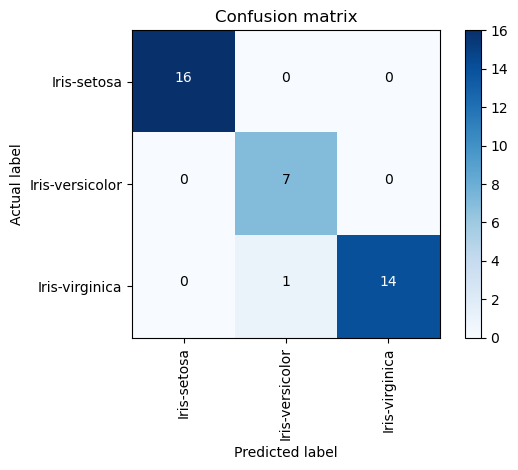

In [10]:
cm = confusion_matrix(y_pred, y_test)
plot_confusion_matrix(cm, np.unique(df[['Class']]))
save_fig('optimal_bayes_classifier_confusion_matrix')

## Sklearn GaussianNB

In [11]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
y_pred = clf.fit(X_train, y_train).predict(X_test)

print('Accuracy: %.2f' % accuracy_score(y_pred, y_test))

Accuracy: 0.95


Saving figure sklearn_nbc_confusion_matrix


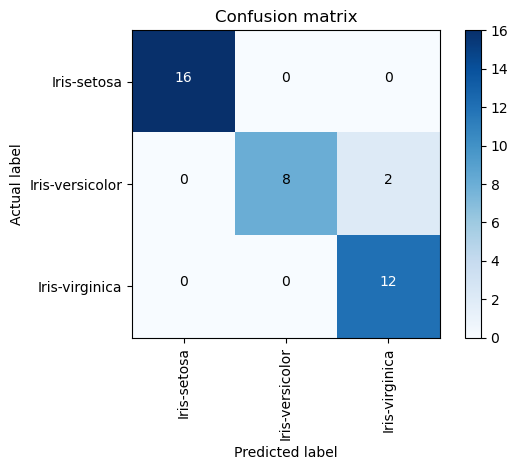

In [12]:
cm = confusion_matrix(y_pred, y_test)
plot_confusion_matrix(cm, np.unique(df[['Class']]))
save_fig('sklearn_naive_bayes_classifier_confusion_matrix')